<a href="https://colab.research.google.com/github/ArifAygun/Advanced-Pandas/blob/main/AA_Graduate_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quality Prediction of Iron Ore Mining Flotation Process - Part:2**

## **5. Modelling**

In [260]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from google.colab import drive

In [261]:
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/
flotation = pd.read_csv('Flotation_Plant_Clean.csv')
flotation.head().T

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


,0,1,2,3,4
date,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00
iron_feed,55.2,55.2,55.2,55.2,55.2
silica_feed,16.98,16.98,16.98,16.98,16.98
starch_flow,301.953,302.441,304.346,304.736,303.369
amina_flow,557.434,563.965,568.054,568.665,558.167
pulp_flow,395.713,397.383,399.668,397.939,400.254
pulp_pH,10.07,10.07,10.07,10.07,10.07
pulp_density,1.74,1.74,1.74,1.74,1.74
airflow_col1,249.214,249.719,249.741,249.917,250.203
airflow_col2,253.235,250.532,247.874,254.487,252.136


In [262]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726453 entries, 0 to 726452
Data columns (total 24 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   date          726453 non-null  object 
 1   iron_feed     726453 non-null  float64
 2   silica_feed   726453 non-null  float64
 3   starch_flow   726453 non-null  float64
 4   amina_flow    726453 non-null  float64
 5   pulp_flow     726453 non-null  float64
 6   pulp_pH       726453 non-null  float64
 7   pulp_density  726453 non-null  float64
 8   airflow_col1  726453 non-null  float64
 9   airflow_col2  726453 non-null  float64
 10  airflow_col3  726453 non-null  float64
 11  airflow_col4  726453 non-null  float64
 12  airflow_col5  726453 non-null  float64
 13  airflow_col6  726453 non-null  float64
 14  airflow_col7  726453 non-null  float64
 15  level_col1    726453 non-null  float64
 16  level_col2    726453 non-null  float64
 17  level_col3    726453 non-null  float64
 18  leve

### **5.1. Grouping Rows with Hourly Frequency**

The importance of considering plant data as a holistic entity was emphasized in order to gain a comprehensive understanding. To achieve this, a loop-based analysis methodology was employed. Each row of data was treated as an individual iteration, representing a complete cycle of feeding 100 tons of ore to the plant, enriching it, and concluding the process. For the purpose of this study, each cycle was set at a duration of one hour. Consequently, a photograph of the plant was captured at hourly intervals and subjected to analysis. It is worth noting that if a more frequent and regular data collection scheme were in place, such as cycles occurring every minute, it would yield a larger dataset suitable for machine learning applications.

In [263]:
flotation.shape

(726453, 24)

In [264]:
flotation['date'] = pd.to_datetime(flotation['date'])
#grouping the data according to the hours and get their average values. 
flotation_grouped = flotation.groupby(pd.Grouper(key='date',freq='H')).mean()
# cycle_data.insert(0,'Date',cycle_data.index)
flotation_grouped.reset_index(inplace = True)

#some rows have 'null' values because of timing. We need to drop them 
print('Shape of Grouped Flotation Dataset = ', flotation_grouped.shape)
flotation = flotation_grouped.dropna()
print('Shape of Grouped Flotation Dataset after drop null values = ', flotation.shape);

Shape of Grouped Flotation Dataset =  (4415, 24)
Shape of Grouped Flotation Dataset after drop null values =  (4097, 24)


In [265]:
missing_values = flotation.isnull().sum()
print(missing_values)

date            0
iron_feed       0
silica_feed     0
starch_flow     0
amina_flow      0
pulp_flow       0
pulp_pH         0
pulp_density    0
airflow_col1    0
airflow_col2    0
airflow_col3    0
airflow_col4    0
airflow_col5    0
airflow_col6    0
airflow_col7    0
level_col1      0
level_col2      0
level_col3      0
level_col4      0
level_col5      0
level_col6      0
level_col7      0
iron_conc       0
silica_conc     0
dtype: int64


In [266]:
duplicates = flotation[flotation.duplicated()]
duplicates.count()

date            0
iron_feed       0
silica_feed     0
starch_flow     0
amina_flow      0
pulp_flow       0
pulp_pH         0
pulp_density    0
airflow_col1    0
airflow_col2    0
airflow_col3    0
airflow_col4    0
airflow_col5    0
airflow_col6    0
airflow_col7    0
level_col1      0
level_col2      0
level_col3      0
level_col4      0
level_col5      0
level_col6      0
level_col7      0
iron_conc       0
silica_conc     0
dtype: int64

In [267]:
flotation.shape

(4097, 24)

The grouping process has a number of advantages and disadvantages.

**Advantages:**
Each analysis will be able to do each data cycle on an hourly frequency.
Date column can be dropped. The number of columns fell to 23.
The number of rows fell to 4097 from 737453. Every rows means calculations on computer.

**Disadvantage:** The number of rows fell to 4097 from 737453. The more rows we have for machine learning, the better results we get. This large data loss will adversely affect our estimation results.

In [268]:
flotation.to_csv('/content/drive/My Drive/Flotation/Flotation_Plant_Grouped.csv', index=False)

### **5.2. Divide Dataset**

Flotation plant product Iron and Silica concentrates namely the last two columns. We will develop separate models for silica and iron in machine learning, so we will separate the columns from the main data as two data types named "iron_concentrate" and "silica_concentrate". The remaining columns are essentially flotation conditions required to enrich the concentrate. We also separate them as "flotation_conditions".

In [269]:
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/
flotation = pd.read_csv('Flotation_Plant_Grouped.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


In [270]:
flotation_conditions = flotation.iloc[:,1:22]
concentrates = flotation.iloc[:,22:]
iron_concentrate = concentrates.iloc[:,0].values
silica_concentrate = concentrates.iloc[:,1].values

print('Shape of flotation_conditions = ', flotation_conditions.shape)
print('Shape of iron_concentrate = ', iron_concentrate.shape)
print('Shape of silica_concentrate = ', silica_concentrate.shape);

Shape of flotation_conditions =  (4097, 21)
Shape of iron_concentrate =  (4097,)
Shape of silica_concentrate =  (4097,)



## **6. P-Value and Confidence Interval**

### **6.1. P-Value**

In [271]:
b_zero = np.append(arr = np.ones((len(flotation.iloc[:,1].values),1)).
                   astype(int), values = flotation_conditions, axis = 1)

silica_concentrate = concentrates.iloc[:,1].values
iron_concentrate = concentrates.iloc[:,0].values;

- (Ordinary Least Squares) OLS Regression for Iron Concentrate

In [272]:
model_iron = sm.OLS(endog = iron_concentrate, exog = b_zero).fit()
print(model_iron.summary());

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     37.00
Date:                Thu, 01 Jun 2023   Prob (F-statistic):          2.51e-137
Time:                        22:34:34   Log-Likelihood:                -5912.7
No. Observations:                4097   AIC:                         1.187e+04
Df Residuals:                    4075   BIC:                         1.201e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.3165      3.762     13.641      0.0

The coefficient for the constant term (intercept) is 51.3165. The p-value for the constant term is 0.000, indicating that the constant term is statistically significant. This means that when all other independent variables are held constant, the expected value of the dependent variable is 51.3165.

The coefficient for iron is 0.0001, suggesting that a one-unit increase in iron is associated with a 0.0001 increase in the dependent variable. However, the p-value for iron is 0.531, which is greater than the typical significance level of 0.05. This implies that the relationship between iron and the dependent variable may not be statistically significant.

The R-squared value for the overall model is 0.160, indicating that approximately 16% of the variability in the dependent variable is explained by the independent variables included in the model. This means that there may be other factors not considered in the model that have an impact on the dependent variable.

It is important to note that the condition number is large (3.83e+05), suggesting the potential presence of multicollinearity. This indicates that some of the independent variables may be highly correlated with each other, which can affect the interpretation of the coefficients.

Considering the significance of the iron variable and the presence of multicollinearity, it may be necessary to further analyze the data, address multicollinearity issues, and explore alternative modeling approaches to gain a better understanding of the relationship between iron and the dependent variable.

- OLS Regression for Silica Concentrate

In [273]:
model_silica = sm.OLS(endog = silica_concentrate,exog = b_zero).fit()
print(model_silica.summary());

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     39.14
Date:                Thu, 01 Jun 2023   Prob (F-statistic):          2.77e-145
Time:                        22:34:34   Log-Likelihood:                -5918.2
No. Observations:                4097   AIC:                         1.188e+04
Df Residuals:                    4075   BIC:                         1.202e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5296      3.767      1.202      0.2

The coefficient for the constant term (intercept) is 4.5296. However, the p-value for the constant term is 0.229, which is greater than the typical significance level of 0.05. This suggests that the constant term is not statistically significant and may not have a meaningful impact on the dependent variable.

The coefficient for silica (x2) is 0.0064, indicating that a one-unit increase in silica is associated with a 0.0064 increase in the dependent variable. However, the p-value for silica is 0.535, which is greater than 0.05. This suggests that the relationship between silica and the dependent variable may not be statistically significant.

It's important to note that the R-squared value for the overall model is 0.168, suggesting that the model explains approximately 16.8% of the variability in the dependent variable. This indicates that there may be other factors not included in the model that are influencing the dependent variable.

The presence of multicollinearity and autocorrelation should also be considered. The condition number is large (3.83e+05), indicating potential multicollinearity issues. This means that some of the independent variables may be highly correlated with each other, which can affect the interpretation of the coefficients. Additionally, the Durbin-Watson statistic is 0.570, suggesting the presence of positive autocorrelation in the residuals.

Finally, the results suggest that silica may not have a statistically significant impact on the dependent variable after accounting for other variables in the model.

- Extract p-value from regression results

In [274]:
pValue_fe = model_iron.pvalues
pValue_si = model_silica.pvalues
pValue_fe_list = []
pValue_si_list = []
for i in range(len(pValue_fe)):
    if i > 0:
        pValue_fe_list.append(pValue_fe[i])
        pValue_si_list.append(pValue_si[i]);

- Plot p-value from regression results

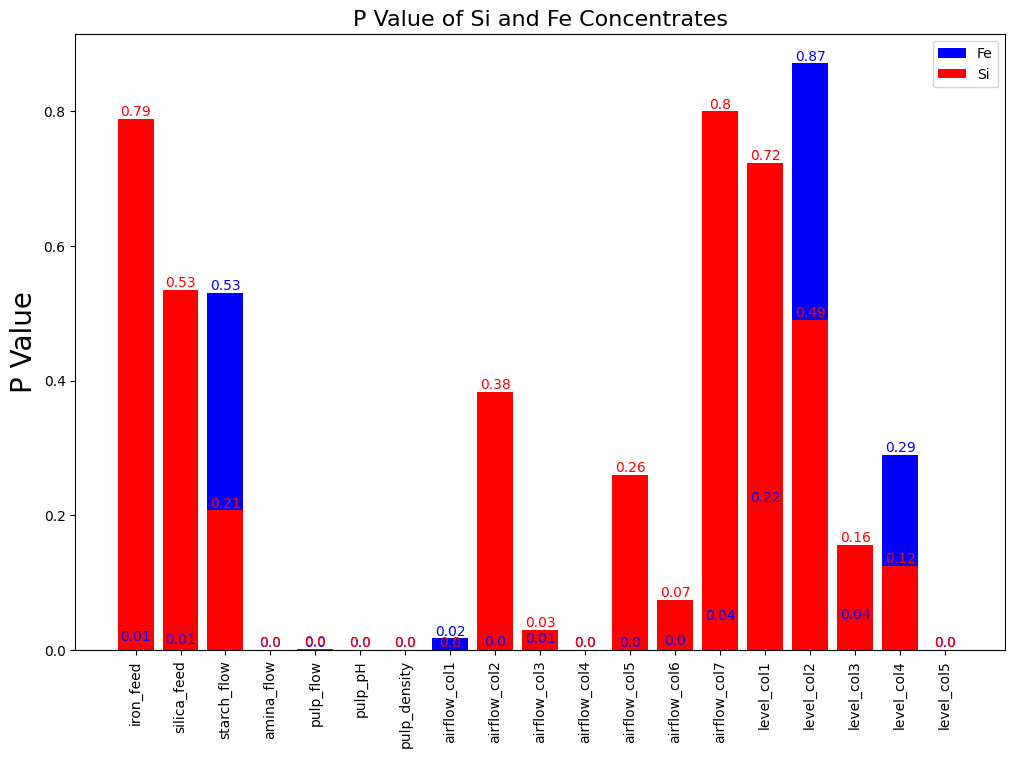

In [275]:
plt.figure(figsize=(12, 8))

plt.bar(t[:-2], fe[:-2], label='Fe', color='blue')
plt.bar(t[:-2], si[:-2], label='Si', color='red')
plt.xticks(rotation=90)

plt.legend(loc="upper right", prop={"size": 10})
plt.ylabel('P Value', fontsize=20)
plt.title('P Value of Si and Fe Concentrates', fontsize=16)

for i, value in enumerate(fe[:-2]):
    plt.text(i, value, f'{round(value, 2)}', 
             ha='center', va='bottom', fontsize=10, color='blue')

for i, value in enumerate(si[:-2]):
    plt.text(i, value, f'{round(value, 2)}', 
             ha='center', va='bottom', fontsize=10, color='red')

plt.show();

When we examine the P values, we see that some values do not affect the concentrated grades. But now we know that this is due to our lack of data.

### **6.2. Confidence Interval**

- Calculate Confidence Intervals for Iron and Silica Concentrates

In [276]:
m_fe = iron_concentrate.mean()
se_fe = iron_concentrate.std() / math.sqrt(len(iron_concentrate))
ci_fe = [m_fe - se_fe * 1.96, m_fe + se_fe * 1.96]

m_si = silica_concentrate.mean()
se_si = silica_concentrate.std() / math.sqrt(len(silica_concentrate))
ci_si = [m_si - se_si * 1.96, m_si + se_si * 1.96]

print('Confidence interval of Fe Concentrate:', ci_fe)
print('Confidence interval of Silica Concentrate:', ci_si);

Confidence interval of Fe Concentrate: [65.01584910543423, 65.08431621905197]
Confidence interval of Silica Concentrate: [2.2922996415958585, 2.3611745080372653]


Metallurgical engineers apply the pouring process to the concentrate we sell and obtain pure iron. There is a grade range they demand from us for this operation: %67 – 68 Fe Grade %1.6 – 1.7 Si Grade In the model we developed according to the confidence interval, the silica values are more than demanded. In the first stage, we need to warn the engineers in the field. (Assuming our data is reliable.)

## **7. Regression Analysis**


### **7.1. R-squared Analysis**

- Calculate R-squared Values for Iron and Silica Concentrates

In [277]:
model_iron = sm.OLS(endog=iron_concentrate, exog=b_zero).fit()
r_squared_iron = model_iron.rsquared
print("R-squared for Iron Concentrate:", r_squared_iron)

model_silica = sm.OLS(endog=silica_concentrate, exog=b_zero).fit()
r_squared_silica = model_silica.rsquared
print("R-squared for Silica Concentrate:", r_squared_silica);

R-squared for Iron Concentrate: 0.16015805019528695
R-squared for Silica Concentrate: 0.1678571233624352


The R-squared value for the regression model predicting the Iron and Silica Concentrate is approximately 0.16. This means that around 16.02% of the variance in the Iron and Silica Concentrate can be explained by the independent variables included in the model. The remaining 83.98% of the variance is attributed to other factors not accounted for in the model. The model has a relatively low explanatory power for the Iron and Silica Concentrate.

### **7.2. Multiple Linear Analysis**

- Calculate Coefficient and Intercepts Values for Iron and Silica Concentrates

In [278]:
from sklearn.linear_model import LinearRegression

# Create the feature matrix X by selecting the flotation conditions
X = flotation_conditions.values

# Create the target variable y for silica concentrate
y_silica = silica_concentrate

# Create the target variable y for iron concentrate
y_iron = iron_concentrate

# Fit the linear regression model for silica concentrate
model_silica = LinearRegression()
model_silica.fit(X, y_silica)

# Fit the linear regression model for iron concentrate
model_iron = LinearRegression()
model_iron.fit(X, y_iron)

print('Coefficients for Silica Concentrate:', model_silica.coef_)
print('**' * 40)
print('Intercept for Silica Concentrate:', model_silica.intercept_)
print('**' * 40)
print('Coefficients for Iron Concentrate:', model_iron.coef_)
print('**' * 40)
print('Intercept for Iron Concentrate:', model_iron.intercept_)
print('**' * 40);

Coefficients for Silica Concentrate: [-3.69352697e-03  6.44613322e-03 -2.39728162e-04  3.99210408e-03
 -6.99841812e-03 -3.34271470e-01 -2.65145208e+00 -9.66793064e-03
  1.07493605e-03 -4.96241848e-03  4.15185588e-02 -6.26676690e-03
  2.57627964e-03 -4.11050119e-04 -9.55041618e-05 -1.70968519e-04
  2.90417007e-04 -5.73952255e-04 -1.77606936e-03  6.80797400e-04
 -3.47802712e-04]
********************************************************************************
Intercept for Silica Concentrate: 4.529631188444176
********************************************************************************
Coefficients for Iron Concentrate: [ 3.62009460e-02  2.88290141e-02  1.18955922e-04 -4.03632258e-03
  1.57288452e-02  4.64589288e-01  3.52228905e+00  4.88542954e-03
 -3.94517235e-03  6.28982535e-03 -4.93550208e-02  3.01315116e-02
 -4.28433583e-03  3.30332874e-03 -3.33488368e-04 -4.01100754e-05
 -4.15938462e-04  3.95094155e-04  1.87580241e-03 -1.18954669e-03
  1.06054821e-03]
****************************

The intercepts in multiple linear regression represent the expected value of the dependent variable (concentrate) when all the independent variables (flotation conditions) are zero. In this case, we have two separate regression models for silica concentrate and iron concentrate.

For **the silica concentrate model** , the intercept of 4.52963118844632 implies that when all the flotation condition variables are set to zero, the expected value of the silica concentrate is approximately 4.53%. This intercept provides a baseline estimate for the silica concentrate without considering any flotation conditions.

Similarly, for **the iron concentrate model**, the intercept of 51.3164828429035 indicates that when all the flotation condition variables are zero, the expected value of the iron concentrate is approximately 51.32%. This intercept serves as a starting point for the iron concentrate prediction in the absence of any flotation conditions.

It's important to note that in practical scenarios, it is unlikely to have all flotation conditions at exactly zero, and the intercept alone may not provide meaningful information. The coefficients of the regression equation should be considered along with the intercept to fully understand the relationship between the flotation conditions and the concentrate values.

To make accurate predictions or draw meaningful conclusions, it is recommended to use actual values of the flotation conditions rather than relying solely on the intercept.

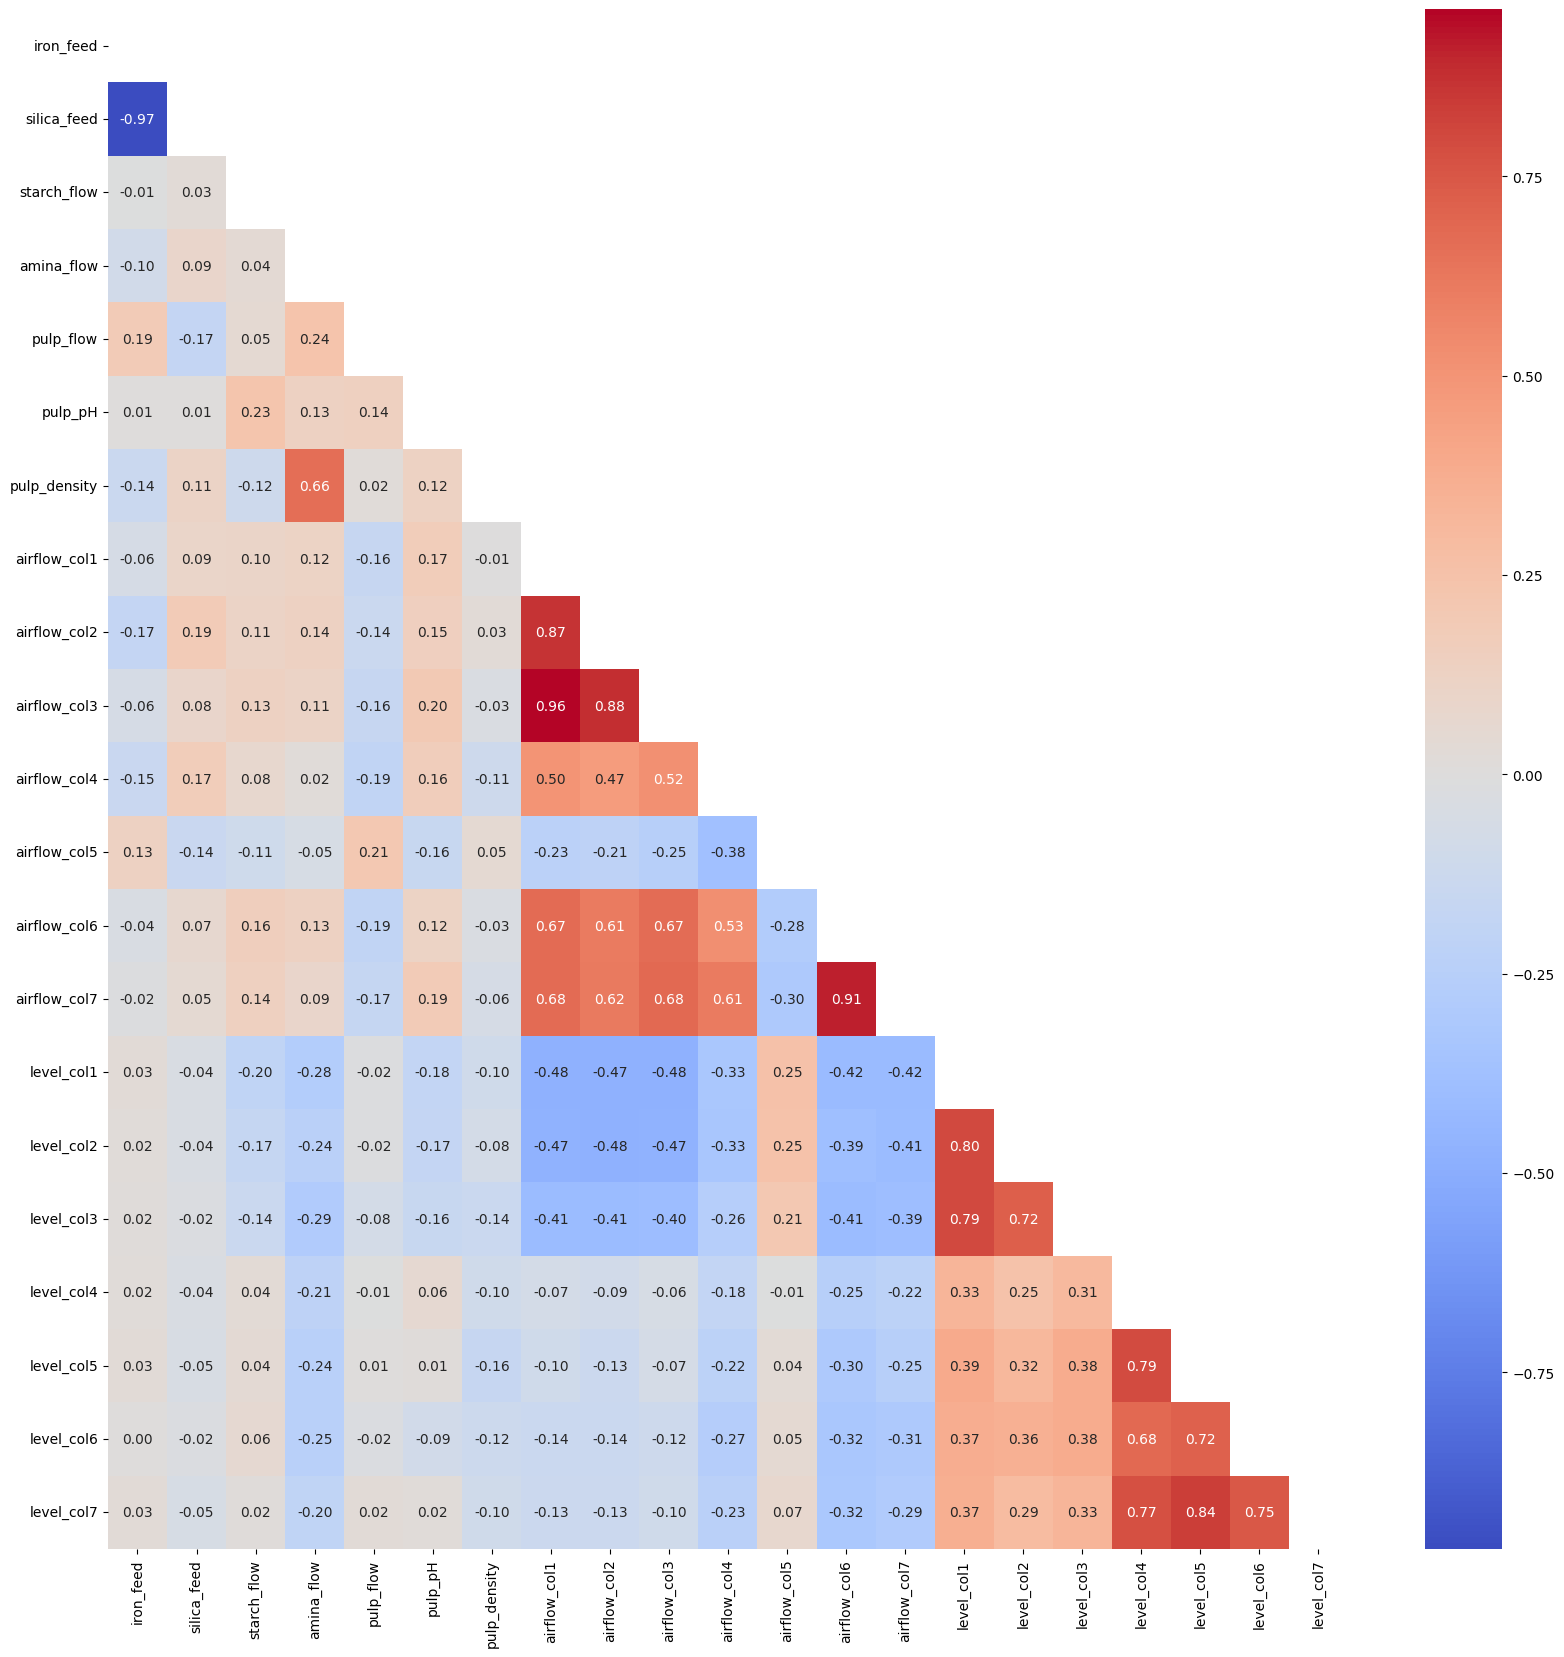

In [279]:
# Compute the correlation matrix
corr_matrix = flotation_conditions.corr()

# Select the features with a correlation above a certain threshold
threshold = 0.5
high_correlation_features = corr_matrix[abs(corr_matrix) > 
                            threshold].stack().dropna().reset_index()
high_correlation_features = high_correlation_features[high_correlation_features['level_0'] != 
                            high_correlation_features['level_1']]
selected_features = set(high_correlation_features['level_0']
                        ).union(set(high_correlation_features['level_1']))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask)
plt.show();

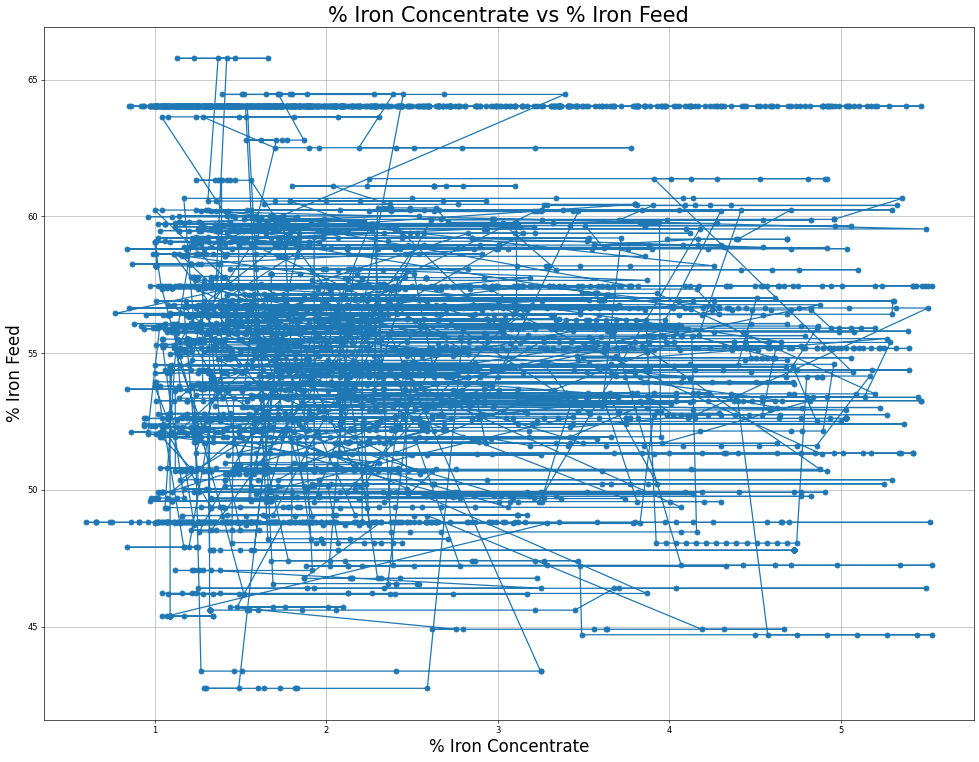

In [280]:
plt.figure(figsize=(20, 15), dpi=60)

x_axis = silica_concentrate
y_axis = flotation_conditions['iron_feed']
plt.plot(x_axis, y_axis, marker='o', label='% Iron Concentrate vs % Iron Feed')
plt.xticks()
plt.xlabel('% Iron Concentrate', fontsize=20)
plt.ylabel('% Iron Feed', fontsize=20)
plt.title('% Iron Concentrate vs % Iron Feed', fontsize=25)
plt.grid(True)
plt.show()


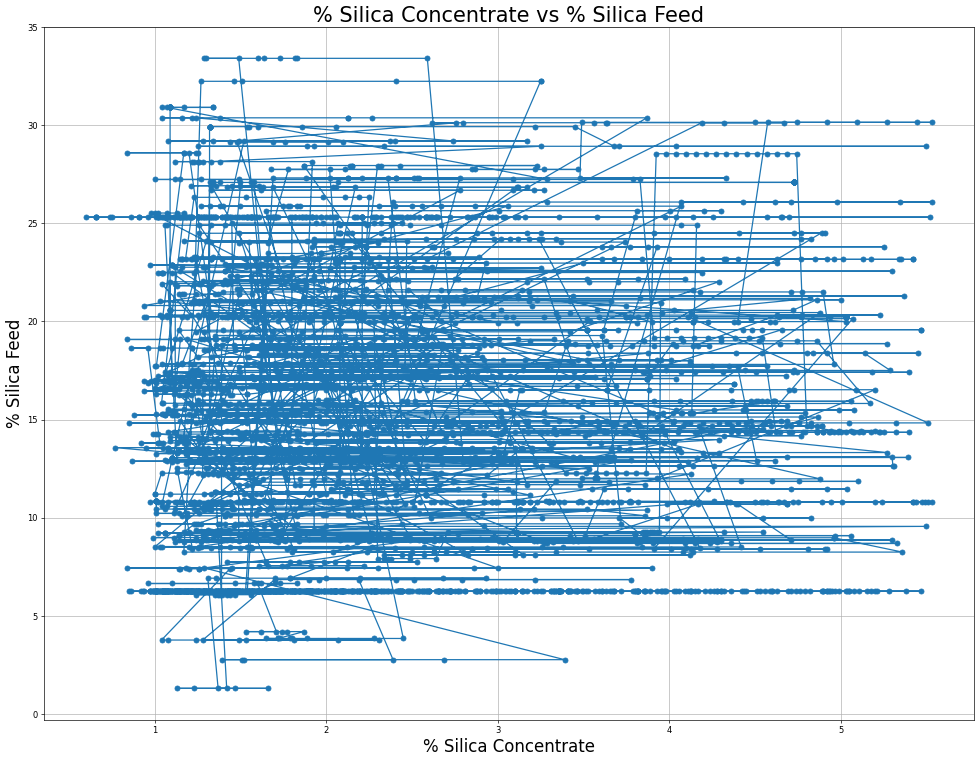

In [281]:
plt.figure(figsize=(20, 15), dpi=60)

x_axis = silica_concentrate
y_axis = flotation_conditions['silica_feed']
plt.plot(x_axis, y_axis, marker='o', label='% Silica Concentrate vs % Silica Feed')
plt.xticks()
plt.xlabel('% Silica Concentrate', fontsize=20)
plt.ylabel('% Silica Feed', fontsize=20)
plt.title('% Silica Concentrate vs % Silica Feed', fontsize=25)
plt.grid(True)
plt.show()


In the plots above, it can be observed that there is no linear relationship between the variables "Iron Feed" and "Iron Concentration," as well as between the variables "Silica Feed" and "Silica Concentration." This example serves to illustrate that there is no significant correlation between these specific variables. However, it is important to note that this observation does not imply the absence of relationships between other columns in the dataset.